In [1]:
import numpy as np
import cv2
import os
import pandas as pd
from collections import Counter as cnt
import matplotlib.pyplot as plt
import torch
import csv
from scipy.stats import chi2_contingency
import pickle
from scipy import stats


from Mymodule.ModelHandler import *
from Mymodule.Utils import *
from Mymodule.GradCam import *
from Mymodule.BatchHandler import *

from collections import Counter as cnt
from torchvision import transforms
from keras import Sequential
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from torch import optim

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

2023-12-03 20:09:18.393682: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 20:09:18.447212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 20:09:19.170827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## for specific confusion matrix

In [2]:
def padd_plot_confusion_matrix(xlabel,ylabel,figsize, conf_matrix, x_labels, y_labels, color, save = True, save_path= './Figures/test.png'):    
    pad_conf_matrix = conf_matrix
    
    plt.figure(figsize=figsize, facecolor='white') # Change this as needed.
    plt.imshow(pad_conf_matrix, interpolation='nearest', cmap=color)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.clim(-30, 350)
    cbar = plt.colorbar(fraction=0.046, pad=0.04, ticks = [0,100,200,300,400])
    cbar.ax.tick_params(labelsize=15)
    plt.tight_layout()
    
    x_posits = np.arange(len(x_labels))
    y_posits = np.arange(len(y_labels))
    plt.xticks(x_posits, x_labels, fontsize = 15)
    plt.yticks(y_posits, y_labels, rotation=90, fontsize = 15)
    
    
    thresh = conf_matrix.max()/2.
    
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            plt.text(j,i, f'''{pad_conf_matrix[i,j]}\n({pad_conf_matrix[i,j]/pad_conf_matrix.sum()*100:.0f}%)''', fontsize=30, horizontalalignment="center", color="white")
    if save == True : plt.savefig(save_path)
    plt.show()

## Prepare Dataset

In [3]:
image_root = './Data/Images/'

clinic_df_path = './Data/231203_PSG.xlsx'

clinic_df = pd.read_excel(clinic_df_path)
clinic_df['sex'] = clinic_df['sex'].map({'F': 0, 'M': 1})
clinic_df.rename(columns={'최저탈포화':'Minimum desaturation'},inplace = True)
clinic_df.rename(columns={'BMI\n':'BMI'},inplace = True)
clinic_df.rename(columns={'PHOE':'PHOB'},inplace = True)
clinic_df.rename(columns={'MRI narrowing ':'MRI narrowing'},inplace = True)
clinic_df.dropna(inplace = True)

print("columns of df : ", clinic_df.columns)

columns of df :  Index(['NO', 'OSA', 'sex', 'Age (avg.)', 'Narrowing of airway ', 'VAS ',
       'Symptom duration (days) ', 'Bruxism', 'Headache', 'Stress', 'Tinnitus',
       'Macrotrauma hx.', 'Height\n(cm)', 'Weight\n(cm)', 'BMI', 'REI', 'OAI',
       'CAI', 'Minimum desaturation', 'O-C', 'I-S', 'DEP', 'ANX', 'HOS',
       'PHOB', 'PAR', 'PSY', 'MRI narrowing'],
      dtype='object')


## Checking images..

In [5]:
train_image_path1 = './Data/Images/1.png'
train_image_path2 = './Data/Images/2.png'
test_image_path1  = './Data/Images/5.png'
test_image_path2  = './Data/Images/17.png'

# pt_no

In [7]:
complete_data_path = "./Data/complete_dataset.pickle"

#for making dataset...
stages = ['train', 'val', 'test']
categorys = ['image','clinic','label']

In [8]:
if not os.path.isfile(complete_data_path):
    data = {}
    for stage in stages: 
        data[stage] = {}
        for category in categorys:
            data[stage][category] = []
    stage = 'train'
    
    for image in os.listdir(image_root):
        if not image[-3:] == 'png': continue
        pt_no = int(image.split('.png')[0])
        clinic_data = clinic_df[clinic_df['NO']==pt_no].values

        image_path = os.path.join(image_root,image)
        reshaped_image = cv2.resize(cv2.imread(image_path, 0),(140,140))
        reshaped_image = np.dstack((reshaped_image,reshaped_image,reshaped_image))
        data[stage]['image'].append(reshaped_image)
        data[stage]['clinic'].append(np.array(clinic_data[0][2:],dtype = 'float16')) 
        data[stage]['label'].append(np.array(clinic_data[0][1],dtype = 'float16'))

    data[stage]['clinic'], data[stage]['image'], data[stage]['label'] = np.array(data[stage]['clinic']), np.array(data[stage]['image']), np.array(data[stage]['label']).reshape(-1,1)

    #train & test split 추가하기..
    #clinic
    data['train']['clinic'],data['test']['clinic'], _, _ = train_test_split(data['train']['clinic'],data['train']['label'], test_size=0.2, random_state=32, stratify=data['train']['label'])
    #image & label
    data['train']['image'],data['test']['image'],data['train']['label'],data['test']['label'] = train_test_split(data['train']['image'], data['train']['label'], test_size=0.2, random_state=32, stratify=data['train']['label'])    
    
    #train & validation
    data['train']['clinic'],data['val']['clinic'], _, _   = train_test_split(data['train']['clinic'],data['train']['label'], test_size=0.2, random_state=32, stratify=data['train']['label'])
    data['train']['image'],data['val']['image'],data['train']['label'],data['val']['label'] = train_test_split(data['train']['image'], data['train']['label'], test_size=0.2, random_state=32, stratify=data['train']['label'])    

    #save data
    with open(complete_data_path,'wb') as fw:
        pickle.dump(data, fw)

elif os.path.isfile(complete_data_path):
    # load data
    with open(complete_data_path, 'rb') as fr:
        data = pickle.load(fr)

# show data
print(data.keys())

dict_keys(['train', 'val', 'test'])


### Model preparation

In [9]:
device = torch.device('cuda:0')

epochs = 30
milestone = [3, 7]
min_epoch = 1
batch = 8
lr = 1e-7

model_name = 'vgg16'

### Training

In [10]:
#for transformation
#... clinic - learning_strategy - mri - group
#... first... without clinic.... to make model...
train_strategies = ['finetuning']

for train_strategy in train_strategies:
    model_save_path = f'./Model/{model_name}_{train_strategy}.pt'

    if not os.path.isfile(model_save_path):
    #if 1 == 1:
        train_x, val_x, test_x = data['train']['image'], data['val']['image'], data['test']['image']
        train_y, val_y, test_y  = data['train']['label'], data['val']['label'], data['test']['label']

        randrot, randvert, randaff = [-15,15], 0.15, [0.1, 1]
        train_transform = [transforms.RandomRotation(randrot), transforms.RandomVerticalFlip(p=randvert), transforms.RandomAffine(0, translate=randaff)]
        train_loader = GetLoader(train_transform, train_x, train_y, batch=batch, test=False)
        val_loader = GetLoader([], val_x, val_y, batch=len(val_y), test=True)
        test_loader = GetLoader([], test_x, test_y, batch=len(test_y), test=True)      

        if train_strategy == 'finetuning'  : model = get_model(model_name, device, pretrained=True, freeze = False)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestone)

        history_t_loss, history_loss, history_auc, history_test_auc, history_train_auc = \
        train_convnet(model, device, train_loader, val_loader, test_loader, lr, epochs, model_save_path,
        optimizer=optimizer, scheduler=scheduler, min_epoch=min_epoch, pos_weight=0, save_by='val_loss', out = True)

        bestepoch = np.argmax(history_auc[min_epoch-1:]) + min_epoch
        print("best epoch : ", bestepoch, " train auc : ",format(history_train_auc[bestepoch-1],".4f"),  " valid auc : ", format(history_auc[bestepoch-1],".4f"), "test auc : ", format(history_test_auc[bestepoch-1],".4f"))

    else : print(f'{model_name}_{train_strategy} already exists')

vgg16_finetuning already exists


### Getting Probability from VGG16 Model

In [11]:
vgg16proba_with_clinicdata_path = './Data/vgg16proba_with_clinicdata.pickle'

if not os.path.isfile(vgg16proba_with_clinicdata_path):
    vgg16proba_with_clinicdata = {}

    sig = torch.nn.Sigmoid()
    
    vgg16proba_with_clinicdata = {}
    for train_strategy in train_strategies:
        vgg16proba_with_clinicdata[train_strategy] = {}
        print(f'train_strategy_{train_strategy}')
        model_save_path = f'./Model/{model_name}_{train_strategy}.pt'

        model = get_model(model_name, device, pretrained=True)    
        model.load_state_dict(torch.load(model_save_path))
        model.eval()

        train_x,      val_x,      test_x      = data['train']['image'] , data['val']['image'] , data['test']['image']
        train_clinic, val_clinic, test_clinic = data['train']['clinic'], data['val']['clinic'], data['test']['clinic']
        train_y,      val_y,      test_y      = data['train']['label'] , data['val']['label'] , data['test']['label']

        randrot, randvert, randaff = [-15,15], 0.15, [0.1, 1]
        train_transform = [transforms.RandomRotation(randrot), transforms.RandomVerticalFlip(p=randvert), transforms.RandomAffine(0, translate=randaff)]

        train_loader = GetLoader(train_transform, train_x, train_y, batch=batch, test=True)
        val_loader = GetLoader([], val_x, val_y, batch=len(val_y), test=True)
        test_loader = GetLoader([], test_x, test_y, batch=len(test_y), test=True)      

        # for getting probabilities from trained vgg16 models.
        with torch.no_grad():
            for stage in stages:
                vgg16proba_with_clinicdata[train_strategy][stage] = {}
                if stage == 'train' : loader = train_loader
                if stage == 'val'   : loader = val_loader
                if stage == 'test'  : loader = test_loader
                check = 0
                for image, label in loader:
                    image, label = image.to(device), label.to(device)
                    logit = model(image)
                    proba, label = sig(logit), label.float()
                    if check ==0: probas, logits, labels = proba, logit,label
                    if check ==1: probas, logits, labels = torch.cat([probas, proba]), torch.cat([logits, logit]), torch.cat([labels, label])
                    check = 1
                vgg16proba_with_clinicdata[train_strategy][stage]['proba'], vgg16proba_with_clinicdata[train_strategy][stage]['logit'], vgg16proba_with_clinicdata[train_strategy][stage]['label'] = probas.cpu().numpy(), logits.cpu().numpy(), labels.cpu().numpy()                
                vgg16proba_with_clinicdata[train_strategy][stage]['clinic'] = data[stage]['clinic']

    #save data
    with open(vgg16proba_with_clinicdata_path,'wb') as fw:
        pickle.dump(vgg16proba_with_clinicdata, fw)

elif os.path.isfile(vgg16proba_with_clinicdata_path):
    print('data exists')
    with open(vgg16proba_with_clinicdata_path, 'rb') as fr:
        vgg16proba_with_clinicdata = pickle.load(fr)
        
vgg16proba_with_clinicdata.keys()

data exists


dict_keys(['finetuning'])

### Training 3 Layer shallow deep learning model

In [12]:
# Is it trustable...??....
# need to check logistic regression....?
model_name = 'OSA_shallow_three_layer'

epochs = 100
milestone = [epochs-10, epochs-6]
min_epoch = 20
batch = 8
lr = 1e-4
scalar = StandardScaler().fit_transform

model_save_path = f'./Model/{model_name}_{train_strategy}.pt'
model = get_model(model_name, device, pretrained=True)    

if not os.path.isfile(model_save_path):
#if 1 == 1:
    train_proba, val_proba, test_proba    = vgg16proba_with_clinicdata['finetuning']['train']['proba'], vgg16proba_with_clinicdata['finetuning']['val']['proba'], vgg16proba_with_clinicdata['finetuning']['test']['proba']
    train_clinic, val_clinic, test_clinic = vgg16proba_with_clinicdata['finetuning']['train']['clinic'], vgg16proba_with_clinicdata['finetuning']['val']['clinic'], vgg16proba_with_clinicdata['finetuning']['test']['clinic']
    train_x, val_x, test_x = np.concatenate([train_proba, train_clinic],axis = -1), np.concatenate([val_proba, val_clinic],axis = -1), np.concatenate([test_proba, test_clinic],axis = -1)
    train_y, val_y, test_y = vgg16proba_with_clinicdata['finetuning']['train']['label'], vgg16proba_with_clinicdata['finetuning']['val']['label'], vgg16proba_with_clinicdata['finetuning']['test']['label']
    temp_train_x, temp_val_x, temp_test_x = [], [], []
    temp_train_y, temp_val_y, temp_test_y = [], [], []
    for i in range(len(train_x)):
        if not np.isnan(train_x[i]).any() : 
            temp_train_x.append(train_x[i])
            temp_train_y.append(train_y[i])
    for i in range(len(val_x)):
        if not np.isnan(val_x[i]).any() : 
            temp_val_x.append(val_x[i])
            temp_val_y.append(val_y[i])
    for i in range(len(test_x)):
        if not np.isnan(test_x[i]).any() : 
            temp_test_x.append(test_x[i])
            temp_test_y.append(test_y[i])
    train_x, val_x, test_x  = scalar(np.array(temp_train_x)), scalar(np.array(temp_val_x)), scalar(np.array(temp_test_x))
    train_y, val_y, test_y  = np.array(temp_train_y), np.array(temp_val_y), np.array(temp_test_y)

    train_loader = GetLoader_for_clinic(train_x, train_y, batch=batch, test=False)
    val_loader   = GetLoader_for_clinic(val_x, val_y, batch=len(val_y), test=True)
    test_loader  = GetLoader_for_clinic(test_x, test_y, batch=len(test_y), test=True)      

    model = get_model(model_name, device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestone)

    history_t_loss, history_loss, history_auc, history_test_auc, history_train_auc = \
    train_convnet(model, device, train_loader, val_loader, test_loader, lr, epochs, model_save_path,
    optimizer=optimizer, scheduler=scheduler, min_epoch=min_epoch, pos_weight=0, save_by='val_loss', out = True)

    bestepoch = np.argmax(history_auc[min_epoch-1:]) + min_epoch
    print("best epoch : ", bestepoch, " train auc : ",format(history_train_auc[bestepoch-1],".4f"),  " valid auc : ", format(history_auc[bestepoch-1],".4f"), "test auc : ", format(history_test_auc[bestepoch-1],".4f"))

else : print(f'{model_name}__{train_strategy} already exists')

OSA_shallow_three_layer__finetuning already exists


### Getting probability from Shallow Three Layer model

In [13]:
STLproba_with_clinicdata_path = './Data/STLproba_with_clinicdata'
model_name = 'OSA_shallow_three_layer'

if not os.path.isfile(STLproba_with_clinicdata_path):
    STLproba_with_clinicdata = {}
    sig = torch.nn.Sigmoid()
    
    STLproba_with_clinicdata = {}
    model_save_path = f'./Model/{model_name}_{train_strategy}.pt'
    model = get_model(model_name, device, pretrained=True)    
    model.load_state_dict(torch.load(model_save_path))
    model.eval()

    train_proba, val_proba, test_proba    = vgg16proba_with_clinicdata['finetuning']['train']['proba'], vgg16proba_with_clinicdata['finetuning']['val']['proba'], vgg16proba_with_clinicdata['finetuning']['test']['proba']
    train_clinic, val_clinic, test_clinic = vgg16proba_with_clinicdata['finetuning']['train']['clinic'], vgg16proba_with_clinicdata['finetuning']['val']['clinic'], vgg16proba_with_clinicdata['finetuning']['test']['clinic']
    train_x, val_x, test_x = np.concatenate([train_proba, train_clinic],axis = -1), np.concatenate([val_proba, val_clinic],axis = -1), np.concatenate([test_proba, test_clinic],axis = -1)
    train_y, val_y, test_y = vgg16proba_with_clinicdata['finetuning']['train']['label'], vgg16proba_with_clinicdata['finetuning']['val']['label'], vgg16proba_with_clinicdata['finetuning']['test']['label']
    temp_train_x, temp_val_x, temp_test_x = [], [], []
    temp_train_y, temp_val_y, temp_test_y = [], [], []

    for i in range(len(train_x)):
        if not np.isnan(train_x[i]).any() : 
            temp_train_x.append(train_x[i])
            temp_train_y.append(train_y[i])
    for i in range(len(val_x)):
        if not np.isnan(val_x[i]).any() : 
            temp_val_x.append(val_x[i])
            temp_val_y.append(val_y[i])
    for i in range(len(test_x)):
        if not np.isnan(test_x[i]).any() : 
            temp_test_x.append(test_x[i])
            temp_test_y.append(test_y[i])

    for stage in stages: STLproba_with_clinicdata[stage] = {}

    STLproba_with_clinicdata['train']['clinic'], STLproba_with_clinicdata['val']['clinic'], STLproba_with_clinicdata['test']['clinic'] = np.array(temp_train_x)[:,1:], np.array(temp_val_x)[:,1:], np.array(temp_test_x)[:,1:]
    train_x, val_x, test_x  = scalar(np.array(temp_train_x, dtype ='float32')), scalar(np.array(temp_val_x, dtype ='float32')), scalar(np.array(temp_test_x, dtype ='float32'))
    train_y, val_y, test_y  = np.array(temp_train_y), np.array(temp_val_y), np.array(temp_test_y)

    train_loader = GetLoader_for_clinic(train_x, train_y, batch=batch, test=True)
    val_loader   = GetLoader_for_clinic(val_x, val_y, batch=len(val_y), test=True)
    test_loader  = GetLoader_for_clinic(test_x, test_y, batch=len(test_y), test=True)      

    # for getting probabilities from trained vgg16 models.
    with torch.no_grad():
        for stage in stages:
            if stage == 'train' : loader = train_loader
            if stage == 'val'   : loader = val_loader
            if stage == 'test'  : loader = test_loader
            check = 0
            for feature, label in loader:
                feature, label = feature.to(device), label.to(device)
                logit = model(feature)
                proba, label = sig(logit), label.float()
                if check ==0: probas, logits, labels = proba, logit,label
                if check ==1: probas, logits, labels = torch.cat([probas, proba]), torch.cat([logits, logit]), torch.cat([labels, label])
                check = 1
            STLproba_with_clinicdata[stage]['proba'], STLproba_with_clinicdata[stage]['logit'], STLproba_with_clinicdata[stage]['label'] = probas.cpu().numpy(), logits.cpu().numpy(), labels.cpu().numpy()                
                

    #save data
    with open(STLproba_with_clinicdata_path,'wb') as fw:
        pickle.dump(STLproba_with_clinicdata, fw)

elif os.path.isfile(STLproba_with_clinicdata_path):
    print('data exists')
    with open(STLproba_with_clinicdata_path, 'rb') as fr:
        STLproba_with_clinicdata = pickle.load(fr)
        
STLproba_with_clinicdata.keys()

data exists


dict_keys(['train', 'val', 'test'])

In [14]:
def get_filtered_result(clinic,proba,label,expert, filter_standard = 'sexage'):
    temp_proba, temp_label, temp_clinic, temp_expert = [], [], [], []
    for i in range(len(clinic)):
        sex, age = clinic[i][0],clinic[i][1]
        if (filter_standard == 'sexage' and not np.isnan(clinic[i][0:2]).any()) or (filter_standard == 'allclinic' and not np.isnan(clinic[i][:]).any()):
            targeted = False
            if group == 'AGE1'   and (age <= 20): targeted = True
            if group == 'AGE2'   and (age >= 21 and age <= 40): targeted = True
            if group == 'AGE3'   and (age >= 41 and age <= 60): targeted = True
            if group == 'AGE4'   and (age >= 61): targeted = True
            if group == 'FEMALE' and (sex == 0): targeted = True
            if group == 'MALE'   and (sex == 1): targeted = True
            if targeted == True:
                temp_proba.append(proba[i])
                temp_label.append(label[i])
                temp_clinic.append(clinic[i])
                temp_expert.append(expert[i])
    proba = np.array(temp_proba)
    label = np.array(temp_label)
    clinic = np.array(temp_clinic)
    expert = np.array(temp_expert)
    return clinic, proba, label, expert

In [27]:
def plot_roc_curve(test_y, proba, title, size=(10,10), color='darkorange', save=True, save_path='./Figures/test', show = True, bootstrap = True):
    roc_auc = metrics.roc_auc_score(test_y, proba)
    fpr, tpr, ths = metrics.roc_curve(test_y, proba)

    best_acc = 0
    best_th = 0
    best_fpr = 0
    best_tpr = 0
    for th in ths:
        pred = decision_func(proba, th)
        acc = metrics.accuracy_score(test_y, pred)
        if acc > best_acc:
            best_acc = acc
            best_th = th
            best_tpr = tpr
            best_fpr = fpr

    # 부트스트래핑을 사용하여 AUC의 95% 신뢰 구간 계산
    
    if bootstrap == True:
        lower_ci, upper_ci = bootstrap_auc(test_y, proba)
        ci_label = '95% CI: {:.4f}-{:.4f}'.format(lower_ci, upper_ci)
    elif bootstrap == False:
        ci_label = ''
        #plt.text(0.5, 0.02, ci_label, ha='center', fontsize=12, transform=plt.gca().transAxes)
    
    if show == True : plt.figure(figsize=size, facecolor='white')
    lw = 2
    plt.plot(fpr, tpr, color=color,
             lw=lw, label=f'''AUC = {roc_auc:.4f}''' )

    plt.plot(best_fpr, best_tpr, color=color)

    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=25)
    plt.ylabel('True Positive Rate', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=16)


    plt.legend(loc="lower right", fontsize=20)

    if save:
        plt.savefig(save_path)
        
    if show == True: plt.show()

    return roc_auc, best_th, best_acc


def padd_plot_confusion_matrix(figsize, xlabel,ylabel, conf_matrix, x_labels, y_labels, color, save = True, save_path= './Figures/test.png'):    
    pad_conf_matrix = conf_matrix
    
    total_num = int(conf_matrix.sum()/2)
    
    plt.figure(figsize=figsize, facecolor='white') # Change this as needed.
    plt.imshow(pad_conf_matrix, interpolation='nearest', cmap=color)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.clim(-10, total_num)
    cbar = plt.colorbar(fraction=0.046, pad=0.04, ticks = [0,1,2,3,4])
    cbar.ax.tick_params(labelsize=15)
    plt.tight_layout()
    
    x_posits = np.arange(len(x_labels))
    y_posits = np.arange(len(y_labels))
    plt.xticks(x_posits, x_labels, fontsize = 15)
    plt.yticks(y_posits, y_labels, rotation=90, fontsize = 15)
    
    
    thresh = conf_matrix.max()/2.
    
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            plt.text(j,i, f'''{pad_conf_matrix[i,j]}\n({pad_conf_matrix[i,j]/pad_conf_matrix.sum()*100:.0f}%)''', fontsize=30, horizontalalignment="center", color="white")
    if save == True : plt.savefig(save_path)
    plt.show()

### Assessment with figures

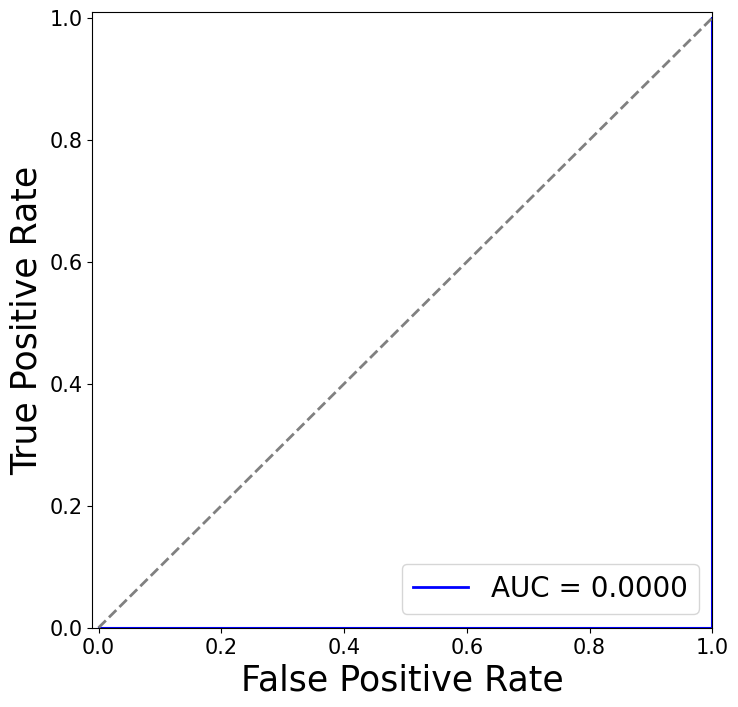

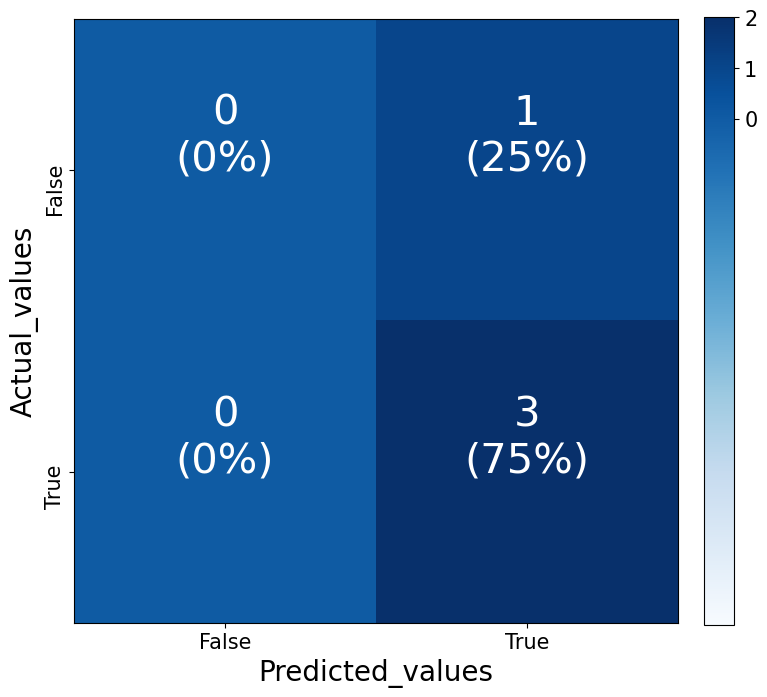

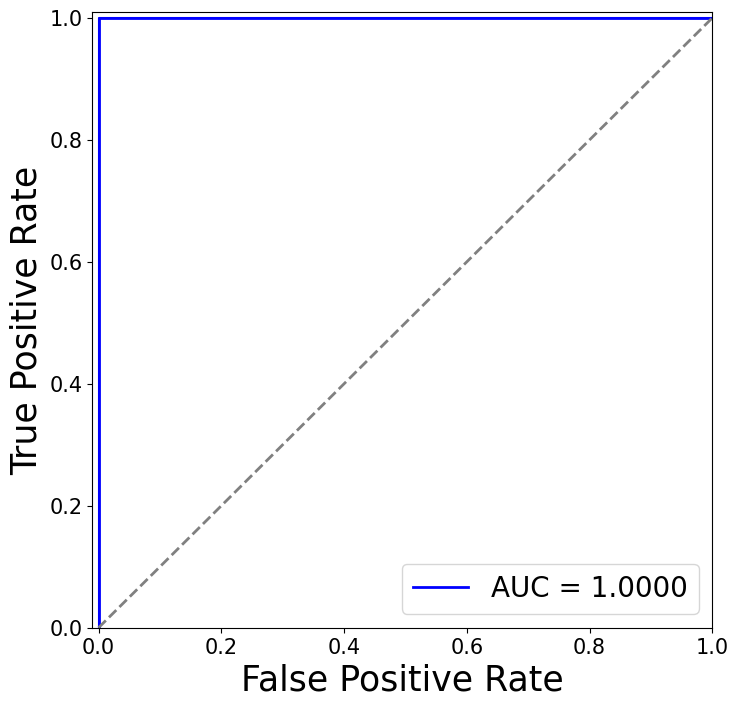

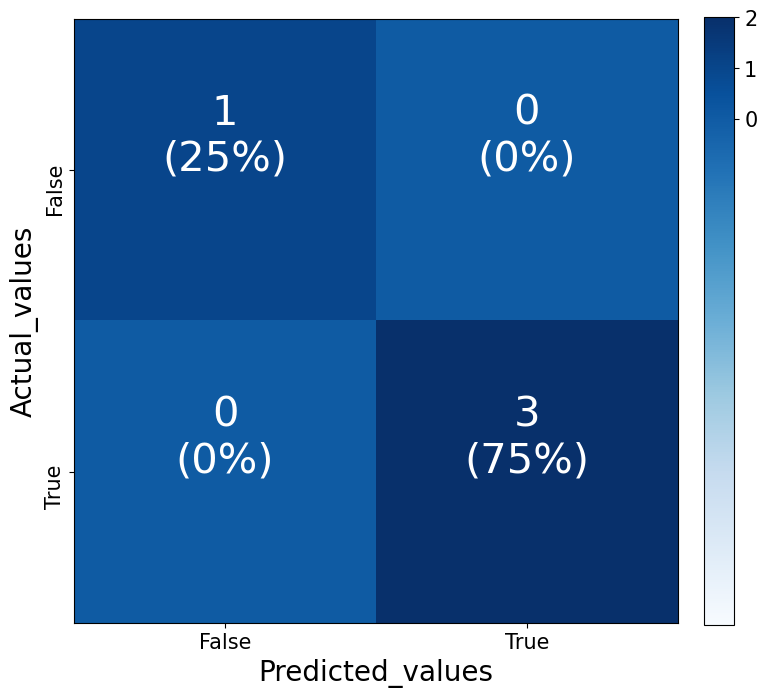

In [28]:
ACCs = {}
# for evaluating Vgg16... for 446 test set..

model_name = 'vgg16'

ACCs['vgg16'] = {}
for train_strategy in train_strategies:
    ACCs['vgg16'][train_strategy] = {}
    # for evaluating vgg16... for 446 test set..
    proba = vgg16proba_with_clinicdata[train_strategy]['test']['proba']
    label = vgg16proba_with_clinicdata[train_strategy]['test']['label']
    clinic = vgg16proba_with_clinicdata[train_strategy]['test']['clinic']

    save = True
    auroc_save_path     = f'''./Figures/AUROC_{model_name}_{train_strategy}.png'''
    confusion_save_path = f'''./Figures/CONFUSION_{model_name}_{train_strategy}.png'''

    if train_strategy == 'finetuning' : 
        auroc_color = 'Blue'
        confusion_color = plt.cm.Blues

    auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8,8), color = auroc_color, save = save, save_path = auroc_save_path, bootstrap = False)
    ACCs['vgg16'][train_strategy]['proba'] = proba
    ACCs['vgg16'][train_strategy]['clinic'] = clinic
    ACCs['vgg16'][train_strategy]['label'] = label
    ACCs['vgg16'][train_strategy]['acc'] = accuracy
    ACCs['vgg16'][train_strategy]['n_pt'] = len(proba)

    pred = decision_func(proba, threshold=threshold)
    conf_mat = confusion_matrix(label, pred)
    padd_plot_confusion_matrix(figsize = (8,8), xlabel = 'Predicted_values', ylabel = 'Actual_values',conf_matrix = conf_mat,x_labels=['False','True'], y_labels=['False','True'], color = confusion_color, save= save, save_path = confusion_save_path)
    ACCs['vgg16'][train_strategy]['pred'] = pred
    
    
# for evaluating shallow_three_layer_network.
ACCs['STL'] = {}
model_name = 'STL'
auroc_color = 'Blue'
confusion_color = plt.cm.Blues


proba = STLproba_with_clinicdata['test']['proba']
label = STLproba_with_clinicdata['test']['label']
clinic = STLproba_with_clinicdata['test']['clinic']

save = True
auroc_save_path     = f'''./Figures/AUROC_{model_name}_{train_strategy}.png'''
confusion_save_path = f'''./Figures/CONFUSION_{model_name}_{train_strategy}.png'''

auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8,8), color = auroc_color, save = save, save_path = auroc_save_path, bootstrap = False)
ACCs['STL']['proba'] = proba
ACCs['STL']['clinic'] = clinic
ACCs['STL']['label'] = label
ACCs['STL']['acc']  = accuracy
ACCs['STL']['n_pt'] = len(proba)

pred = decision_func(proba, threshold=threshold)
conf_mat = confusion_matrix(label, pred)
padd_plot_confusion_matrix(figsize = (8,8), xlabel = 'Predicted_values', ylabel = 'Actual_values',conf_matrix = conf_mat,x_labels=['False','True'], y_labels=['False','True'], color = confusion_color, save= save, save_path = confusion_save_path)
ACCs['STL']['pred'] = pred